# 3.2-3.4 Benchmark Trading Strategies

Replication of **Figures 1, 2, and 3** from Zhang (2021) "Pairs trading with general state space models"

**Section 3.2** - Benchmark strategies (Strategy A & B)
**Section 3.3** - Trading Rules (optimal U and L)  
**Section 3.4** - New Strategy C (homoscedastic vs heteroscedastic)

## Setup and Spread Simulation

In [1]:
import sys
from pathlib import Path

# Add src to path
src_path = Path.cwd().parent / "src"
if str(src_path) not in sys.path:
    sys.path.insert(0, str(src_path))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Use existing project modules
from pairs_ssm.models.model_specs import SIMULATION_MODELS, SimulationSpec
from pairs_ssm.trading.strategy import strategy_A_signals, strategy_B_signals, strategy_C_signals
from pairs_ssm.optimization.simulator import simulate_ou_process

print("✓ Using existing pairs_ssm modules:")
print(f"  - Model specs: {list(SIMULATION_MODELS.keys())}")
print(f"  - Strategies: A, B, C")

✓ Using existing pairs_ssm modules:
  - Model specs: ['model_1', 'model_2', 'model_3', 'model_4', 'model_5']
  - Strategies: A, B, C


## Figure 1: Trading Strategy A

**Strategy A**: Open a trade when spread ≥ U (sell A, buy γB) or spread ≤ L (buy A, sell γB).  
Close the trade when spread returns to mean C.

In [2]:
# Simulate spread using Model 1 spec (AR(1) Gaussian)
model1 = SIMULATION_MODELS["model_1"]
print(f"Model 1: {model1.description}")

np.random.seed(42)

def simulate_spread_from_spec(spec: SimulationSpec, n_steps: int = 250, x0: float = 0.0) -> np.ndarray:
    """Simulate spread using model spec from the paper."""
    x = np.zeros(n_steps)
    x[0] = x0
    
    for t in range(1, n_steps):
        # Get volatility (heteroscedastic if q_het > 0)
        vol = np.sqrt(spec.sigma**2 + spec.q_het * x[t-1]**2)
        
        # State transition: x_{t+1} = θ₀ + θ₁x + θ₂x² + σ*η
        x[t] = spec.theta0 + spec.theta1 * x[t-1] + spec.theta2 * x[t-1]**2 + vol * np.random.randn()
    
    return x

# Simulate and scale for visualization
spread = simulate_spread_from_spec(model1, n_steps=250) * 15  # Scale for visibility

# Define thresholds
U = 0.08   # Upper boundary
L = -0.08  # Lower boundary  
C = 0.0    # Mean (exit level)

print(f"Spread simulated: {len(spread)} steps")
print(f"Thresholds: U={U}, L={L}, C={C}")

Model 1: Simple AR(1): x_{t+1} = 0.9590 x_t + 0.0049 η_t
Spread simulated: 250 steps
Thresholds: U=0.08, L=-0.08, C=0.0


In [3]:
# Figure 1: Strategy A using existing trading module
signals_A = strategy_A_signals(spread, U=U, L=L, C=C)

# Find trade entry/exit points
def find_trades(signals: pd.Series):
    """Find trade entry and exit points from signals."""
    trades = []
    in_trade = False
    entry_idx = None
    trade_type = None
    
    for t in range(1, len(signals)):
        if not in_trade and signals.iloc[t] != 0:
            # Enter trade
            in_trade = True
            entry_idx = t
            trade_type = 'short' if signals.iloc[t] == -1 else 'long'
        elif in_trade and signals.iloc[t] == 0:
            # Exit trade
            trades.append({'entry': entry_idx, 'exit': t, 'type': trade_type})
            in_trade = False
    return trades

trades_A = find_trades(signals_A)
print(f"Strategy A: {len(trades_A)} completed trades")

Strategy A: 11 completed trades


## Figure 2: Trading Strategy B

**Strategy B**: Open trade when spread *crosses* U from below or L from above.  
Hold until spread crosses the *opposite* boundary.

In [4]:
# Figure 2: Strategy B using existing trading module  
U_b, L_b = 0.06, -0.06
signals_B = strategy_B_signals(spread, U=U_b, L=L_b)

trades_B = find_trades(signals_B)
print(f"Strategy B: {len(trades_B)} completed trades")

Strategy B: 0 completed trades


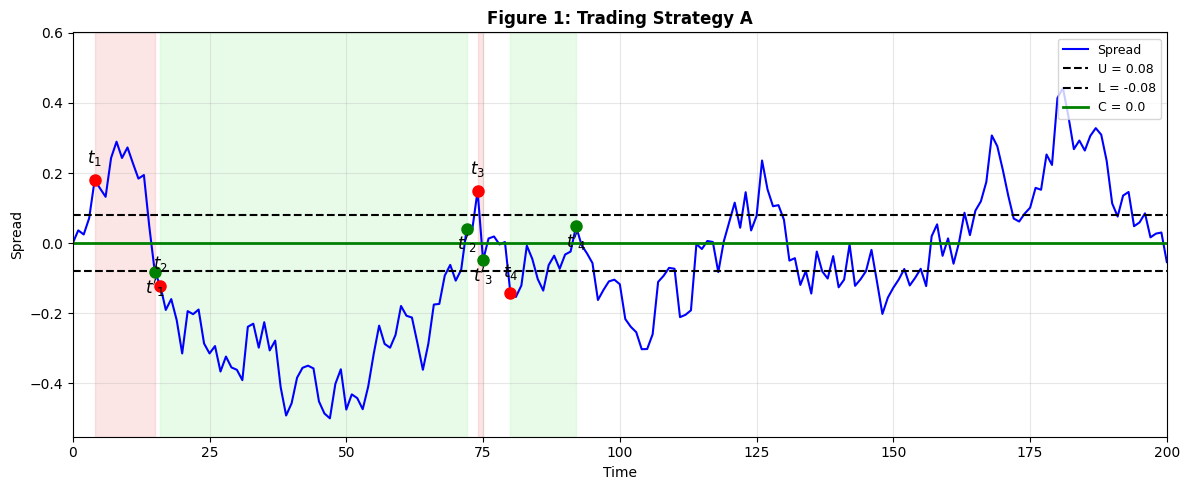

In [5]:
def plot_strategy(spread, trades, U, L, C, title, ax):
    """Plot spread with trade entry/exit points."""
    time = np.arange(len(spread))
    ax.plot(time, spread, 'b-', linewidth=1.5, label='Spread')
    ax.axhline(y=U, color='k', linestyle='--', linewidth=1.5, label=f'U = {U}')
    ax.axhline(y=L, color='k', linestyle='--', linewidth=1.5, label=f'L = {L}')
    ax.axhline(y=C, color='green', linestyle='-', linewidth=2, label=f'C = {C}')
    
    labels = ['$t_1$', '$t_2$', '$t_3$', '$t_4$']
    exit_labels = ["$t'_1$", "$t'_2$", "$t'_3$", "$t'_4$"]
    
    for i, trade in enumerate(trades[:4]):
        color = 'lightcoral' if trade['type'] == 'short' else 'lightgreen'
        ax.axvspan(trade['entry'], trade['exit'], alpha=0.2, color=color)
        ax.plot(trade['entry'], spread[trade['entry']], 'ro', markersize=8)
        ax.plot(trade['exit'], spread[trade['exit']], 'go', markersize=8)
        if i < len(labels):
            ax.annotate(labels[i], (trade['entry'], spread[trade['entry']]),
                       textcoords="offset points", xytext=(0, 12), fontsize=12, ha='center')
            ax.annotate(exit_labels[i], (trade['exit'], spread[trade['exit']]),
                       textcoords="offset points", xytext=(0, -15), fontsize=12, ha='center')
    
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.set_xlabel('Time')
    ax.set_ylabel('Spread')
    ax.legend(loc='upper right', fontsize=9)
    ax.grid(True, alpha=0.3)
    ax.set_xlim(0, 200)

# Plot Figure 1
fig, ax = plt.subplots(figsize=(12, 5))
plot_strategy(spread, trades_A, U, L, C, 'Figure 1: Trading Strategy A', ax)
plt.tight_layout()
plt.show()

## Figure 3: Trading Strategy C (New Strategy)

**Strategy C** (the paper's contribution): 
- Open when spread crosses U **from above** (not below) or L **from below** (not above)
- Close when spread crosses mean C, OR when spread crosses U from below / L from above

Two cases:
- **(a) Homoscedastic** - constant volatility, boundaries are fixed
- **(b) Heteroscedastic** - time-varying volatility, boundaries adapt

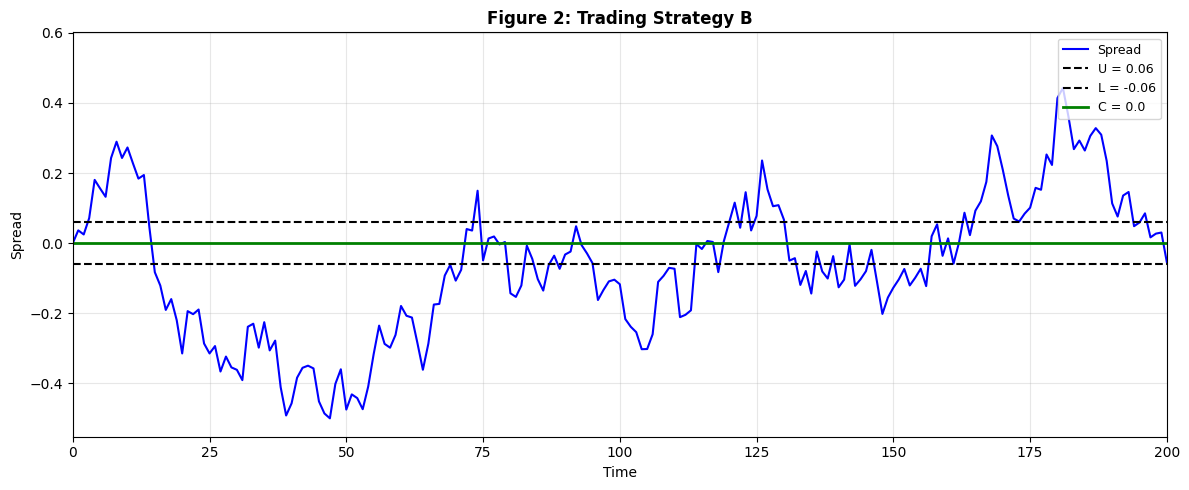

In [6]:
# Plot Figure 2: Strategy B
fig, ax = plt.subplots(figsize=(12, 5))
plot_strategy(spread, trades_B, U_b, L_b, C, 'Figure 2: Trading Strategy B', ax)
plt.tight_layout()
plt.show()

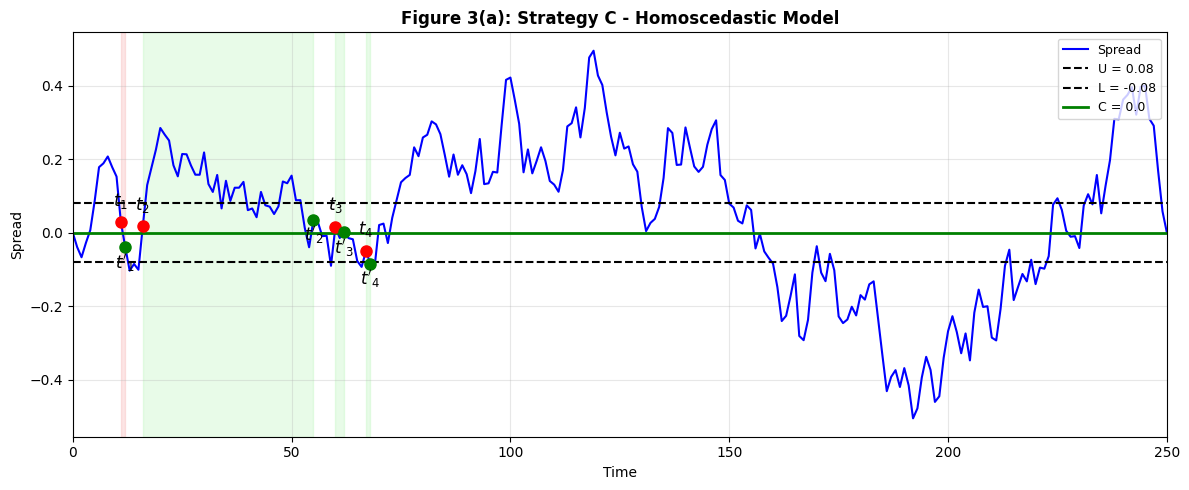

Strategy C (homoscedastic): 20 completed trades


In [7]:
# Figure 3(a): Strategy C with homoscedastic Model 1
np.random.seed(456)
spread_c = simulate_spread_from_spec(model1, n_steps=300) * 12

U_c, L_c = 0.08, -0.08
signals_C = strategy_C_signals(spread_c, U=U_c, L=L_c, C=C)
trades_C = find_trades(signals_C)

fig, ax = plt.subplots(figsize=(12, 5))
plot_strategy(spread_c, trades_C, U_c, L_c, C, 'Figure 3(a): Strategy C - Homoscedastic Model', ax)
ax.set_xlim(0, 250)
plt.tight_layout()
plt.show()

print(f"Strategy C (homoscedastic): {len(trades_C)} completed trades")

In [8]:
# Figure 3(b): Strategy C with heteroscedastic Model 3
model3 = SIMULATION_MODELS["model_3"]
print(f"Model 3: {model3.description}")

np.random.seed(789)
spread_hetero = simulate_spread_from_spec(model3, n_steps=300) * 4

# Compute dynamic boundaries based on rolling volatility
def compute_dynamic_boundaries(spread, k=2.0, window=20):
    """Compute time-varying U(t) and L(t) based on local volatility."""
    vol = pd.Series(spread).rolling(window, min_periods=5).std().fillna(0.02).values
    vol = np.maximum(vol, 0.01)
    return k * vol, -k * vol

U_t, L_t = compute_dynamic_boundaries(spread_hetero)

signals_C_het = strategy_C_signals(spread_hetero, U=U_t.mean(), L=L_t.mean(), C=C)
trades_C_het = find_trades(signals_C_het)

print(f"Strategy C (heteroscedastic): {len(trades_C_het)} completed trades")

Model 3: Heteroscedastic: x_{t+1} = 0.959 x_t + sqrt(0.00089 + 0.08 x_t²) η_t
Strategy C (heteroscedastic): 15 completed trades


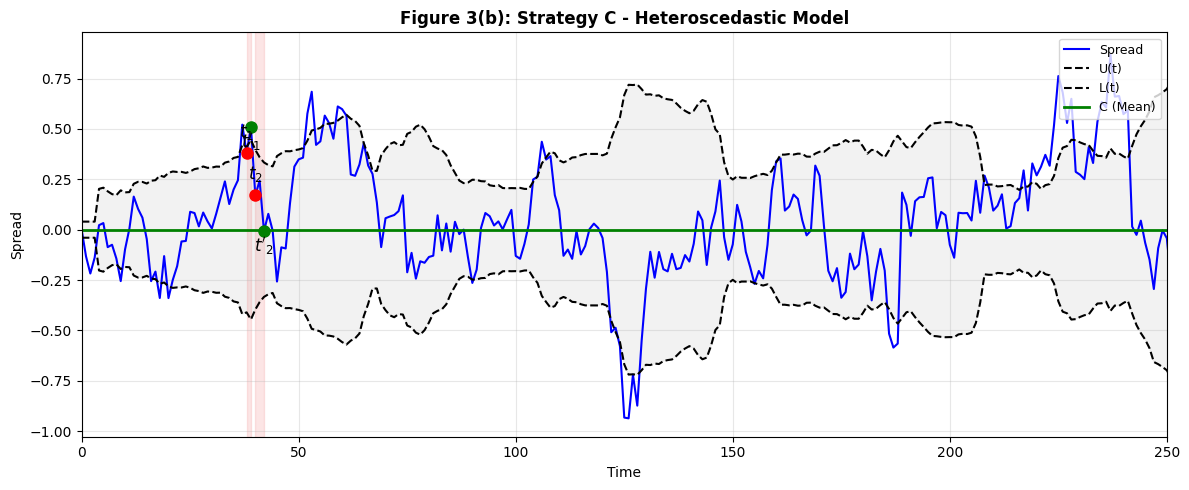

In [9]:
# Plot Figure 3(b) with dynamic boundaries
fig, ax = plt.subplots(figsize=(12, 5))

time_h = np.arange(len(spread_hetero))
ax.plot(time_h, spread_hetero, 'b-', linewidth=1.5, label='Spread')
ax.plot(time_h, U_t, 'k--', linewidth=1.5, label='U(t)')
ax.plot(time_h, L_t, 'k--', linewidth=1.5, label='L(t)')
ax.axhline(y=C, color='green', linestyle='-', linewidth=2, label='C (Mean)')
ax.fill_between(time_h, L_t, U_t, alpha=0.1, color='gray')

labels = ['$t_1$', '$t_2$']
exit_labels = ["$t'_1$", "$t'_2$"]
for i, trade in enumerate(trades_C_het[:2]):
    ax.axvspan(trade['entry'], trade['exit'], alpha=0.2, 
               color='lightcoral' if trade['type'] == 'short' else 'lightgreen')
    ax.plot(trade['entry'], spread_hetero[trade['entry']], 'ro', markersize=8)
    ax.plot(trade['exit'], spread_hetero[trade['exit']], 'go', markersize=8)
    ax.annotate(labels[i], (trade['entry'], spread_hetero[trade['entry']]),
               textcoords="offset points", xytext=(0, 12), fontsize=12, ha='center')
    ax.annotate(exit_labels[i], (trade['exit'], spread_hetero[trade['exit']]),
               textcoords="offset points", xytext=(0, -15), fontsize=12, ha='center')

ax.set_title('Figure 3(b): Strategy C - Heteroscedastic Model', fontsize=12, fontweight='bold')
ax.set_xlabel('Time')
ax.set_ylabel('Spread')
ax.legend(loc='upper right', fontsize=9)
ax.grid(True, alpha=0.3)
ax.set_xlim(0, 250)

plt.tight_layout()
plt.show()

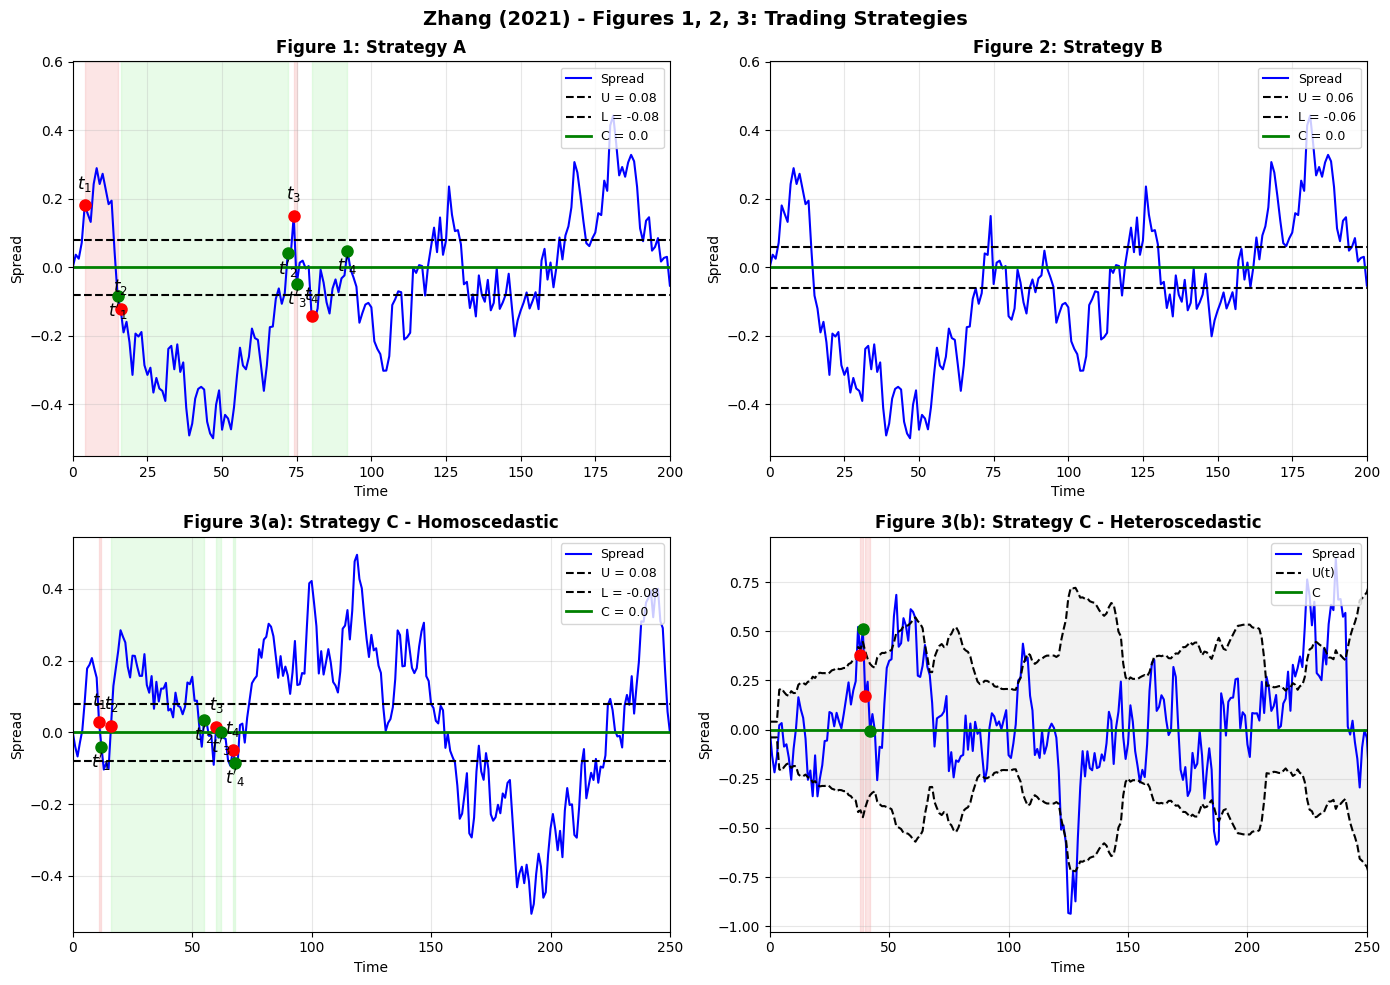

✅ All figures replicated using existing pairs_ssm modules!


In [10]:
# Combined Figure: All 4 plots (like in paper)
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Figure 1: Strategy A
plot_strategy(spread, trades_A, U, L, C, 'Figure 1: Strategy A', axes[0, 0])

# Figure 2: Strategy B  
plot_strategy(spread, trades_B, U_b, L_b, C, 'Figure 2: Strategy B', axes[0, 1])

# Figure 3(a): Strategy C - Homo
plot_strategy(spread_c, trades_C, U_c, L_c, C, 'Figure 3(a): Strategy C - Homoscedastic', axes[1, 0])
axes[1, 0].set_xlim(0, 250)

# Figure 3(b): Strategy C - Hetero (with dynamic boundaries)
ax = axes[1, 1]
ax.plot(time_h, spread_hetero, 'b-', linewidth=1.5, label='Spread')
ax.plot(time_h, U_t, 'k--', linewidth=1.5, label='U(t)')
ax.plot(time_h, L_t, 'k--', linewidth=1.5)
ax.axhline(y=C, color='green', linestyle='-', linewidth=2, label='C')
ax.fill_between(time_h, L_t, U_t, alpha=0.1, color='gray')
for trade in trades_C_het[:2]:
    ax.axvspan(trade['entry'], trade['exit'], alpha=0.2, 
               color='lightcoral' if trade['type'] == 'short' else 'lightgreen')
    ax.plot(trade['entry'], spread_hetero[trade['entry']], 'ro', markersize=8)
    ax.plot(trade['exit'], spread_hetero[trade['exit']], 'go', markersize=8)
ax.set_title('Figure 3(b): Strategy C - Heteroscedastic', fontsize=12, fontweight='bold')
ax.set_xlabel('Time')
ax.set_ylabel('Spread')
ax.legend(loc='upper right', fontsize=9)
ax.grid(True, alpha=0.3)
ax.set_xlim(0, 250)

plt.suptitle('Zhang (2021) - Figures 1, 2, 3: Trading Strategies', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("✅ All figures replicated using existing pairs_ssm modules!")